# Fine-tune Gemma on Sagemaker with QLoRA
* Notebook by Adam Lang
* Date: 12/26/2024

# Workflow Overview
- Notebook running with a different EC2 instance type on AWS SageMaker
- Use Huggingface library
  - SQL generator Dataset from Huggingface
  - Transformer with Gemma model
  - SFT Trainer from TRL library by HugginFace
  - QLoRA based training from PEFT
  - Deploy using saved artifacts on S3
  - evaluate the model

In [1]:
## install requirements 
! pip install -r ./requirements_local.txt

  Attempting uninstall: dill
    Found existing installation: dill 0.3.9
    Uninstalling dill-0.3.9:
      Successfully uninstalled dill-0.3.9
  Attempting uninstall: datasets
    Found existing installation: datasets 2.2.1
    Uninstalling datasets-2.2.1:
      Successfully uninstalled datasets-2.2.1
  Attempting uninstall: boto3
    Found existing installation: boto3 1.34.162
    Uninstalling boto3-1.34.162:
      Successfully uninstalled boto3-1.34.162
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.1.1 requires nvidia-ml-py3==7.352.0, which is not installed.
amazon-sagemaker-sql-magic 0.1.3 requires sqlparse==0.5.0, but you have sqlparse 0.5.1 which is incompatible.
autogluon-core 1.1.1 requires scikit-learn<1.4.1,>=1.3.0, but you have scikit-learn 1.5.2 which is incompatible.
autogluon-core 1.1.1 requires scipy<1.13,>=1.5.4, but you

# ADD HF_TOKEN
* Create a `.env` file and add your token there with variable of `HF_TOKEN`.

# Setup SageMaker

In [14]:
import dotenv
import sagemaker
import boto3
from botocore.exceptions import ClientError

print(dotenv.load_dotenv('./.env'))

USER_ID = 'adam'
s3_bucket = f"{USER_ID}-llmops-sagemaker-test"

job_name = f"{USER_ID}-qlora-gemma-2b-sql-generator"
deploy_model_name = f"{USER_ID}-sql-generator-model"

# role_name = "llmops_workshop_sagemaker_exec_role"

train_instance = 'ml.g5.2xlarge'
deploy_instance = 'ml.g5.2xlarge'
model_id = "google/gemma-2b-it"

train_local, train_path = './tmp/train.jsonl', 'dataset/train.jsonl'
test_local, test_path = './tmp/test.jsonl', 'dataset/test.jsonl'

## check if bucket exists
def bucket_exists(bucket_name, region="eu-central-1"):
    s3_client = boto3.client('s3', region_name=region)
    try:
        s3_client.head_bucket(Bucket=bucket_name)
        return True
    except ClientError:
        return False

# s3_bucket = sess.default_bucket()
def create_bucket(bucket_name, region="eu-central-1"):
    if not bucket_exists(bucket_name, region):
        s3_client = boto3.client('s3', region_name=region)
        try:
            location = {'LocationConstraint': region}
            s3_client.create_bucket(Bucket=bucket_name, CreateBucketConfiguration=location)
            print(f"Bucket {bucket_name} created successfully")
        except ClientError as e:
            print(f"Error creating bucket {bucket_name}: {e.response['Error']['Message']}")
    else:
        print(f"Bucket {bucket_name} already exists")

create_bucket(s3_bucket)


try:
    role = sagemaker.get_execution_role()
except ValueError:
    print("Unable to get the SageMaker execution role. Make sure you're running this in a SageMaker notebook instance or Studio.")
    # If you know your role ARN, you can set it manually:
    role = "arn:aws:iam::431002633201:role/AWSReservedSSO_poweruser-access_7a2a49e90a72f9b2"
    raise

sess = sagemaker.Session(default_bucket=s3_bucket)

print(f"{role =}")
print(f"{s3_bucket =}")
print(f"{sess.boto_region_name =}")

True
Bucket adam-llmops-sagemaker-test already exists
role ='arn:aws:iam::431002633201:role/whiq-sm-studio-role'
s3_bucket ='adam-llmops-sagemaker-test'
sess.boto_region_name ='eu-central-1'


# Dataset Overview
* This is a synthetic dataset of text to sql samples: https://huggingface.co/datasets/gretelai/synthetic_text_to_sql

In [15]:
import datasets

DATASET = "gretelai/synthetic_text_to_sql"
ds = datasets.load_dataset(DATASET)

In [16]:
print(ds.shape)
ds

{'train': (100000, 11), 'test': (5851, 11)}


DatasetDict({
    train: Dataset({
        features: ['id', 'domain', 'domain_description', 'sql_complexity', 'sql_complexity_description', 'sql_task_type', 'sql_task_type_description', 'sql_prompt', 'sql_context', 'sql', 'sql_explanation'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['id', 'domain', 'domain_description', 'sql_complexity', 'sql_complexity_description', 'sql_task_type', 'sql_task_type_description', 'sql_prompt', 'sql_context', 'sql', 'sql_explanation'],
        num_rows: 5851
    })
})

In [17]:
ds["train"].features

{'id': Value(dtype='int32', id=None),
 'domain': Value(dtype='string', id=None),
 'domain_description': Value(dtype='string', id=None),
 'sql_complexity': Value(dtype='string', id=None),
 'sql_complexity_description': Value(dtype='string', id=None),
 'sql_task_type': Value(dtype='string', id=None),
 'sql_task_type_description': Value(dtype='string', id=None),
 'sql_prompt': Value(dtype='string', id=None),
 'sql_context': Value(dtype='string', id=None),
 'sql': Value(dtype='string', id=None),
 'sql_explanation': Value(dtype='string', id=None)}

In [18]:
## sample query from the synthetic dataset
for label, val in ds["train"][0].items():
    print(f"{label}: {val}\n\n")

id: 5097


domain: forestry


domain_description: Comprehensive data on sustainable forest management, timber production, wildlife habitat, and carbon sequestration in forestry.


sql_complexity: single join


sql_complexity_description: only one join (specify inner, outer, cross)


sql_task_type: analytics and reporting


sql_task_type_description: generating reports, dashboards, and analytical insights


sql_prompt: What is the total volume of timber sold by each salesperson, sorted by salesperson?


sql_context: CREATE TABLE salesperson (salesperson_id INT, name TEXT, region TEXT); INSERT INTO salesperson (salesperson_id, name, region) VALUES (1, 'John Doe', 'North'), (2, 'Jane Smith', 'South'); CREATE TABLE timber_sales (sales_id INT, salesperson_id INT, volume REAL, sale_date DATE); INSERT INTO timber_sales (sales_id, salesperson_id, volume, sale_date) VALUES (1, 1, 120, '2021-01-01'), (2, 1, 150, '2021-02-01'), (3, 2, 180, '2021-01-01');


sql: SELECT salesperson_id, name, SUM(vo

# Prepare Dataset

In [20]:
USER_PROMPT_TEMPLATE = """ 
You are a database management system expert, proficient in Structured Query Language (SQL). 
Your job is to write an SQL query that answers the following question, based on the given database schema and any additional information provided. 
Use SQLite syntax and please output only SQL without any kind of explanations. 
### Schema: {sql_context} 
 
### Knowledge: This "{sql_task_type}" type task is commonly used for {sql_task_type_description} in the domain of {domain}, which involves {domain_description}. 
 
### Question: {sql_prompt} 
"""

In [22]:
## helper function to convert to conversation type 
## for huggingface to process
def get_messages(item_dict):
    return { "messages": [
        {"role": "user", "content": USER_PROMPT_TEMPLATE.format(**item_dict)},
        {"role": "assistant", "content": item_dict["sql"]}
        ]
    }

In [23]:
from transformers import AutoTokenizer

## init tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

## map to dataset
formated_ds = ds.map(get_messages, remove_columns=ds["train"].features, batched=False)
formated_ds["train"][5]

/opt/conda/lib/python3.11/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5851 [00:00<?, ? examples/s]

{'messages': [{'content': ' \nYou are a database management system expert, proficient in Structured Query Language (SQL). \nYour job is to write an SQL query that answers the following question, based on the given database schema and any additional information provided. \nUse SQLite syntax and please output only SQL without any kind of explanations. \n### Schema: CREATE SCHEMA if not exists defense; CREATE TABLE if not exists eu_humanitarian_assistance (id INT PRIMARY KEY, year INT, spending INT); INSERT INTO defense.eu_humanitarian_assistance (id, year, spending) VALUES (1, 2019, 1500), (2, 2020, 1800), (3, 2021, 2100); \n \n### Knowledge: This "analytics and reporting" type task is commonly used for generating reports, dashboards, and analytical insights in the domain of defense operations, which involves Defense data on military innovation, peacekeeping operations, defense diplomacy, and humanitarian assistance.. \n \n### Question: What is the total spending on humanitarian assistan

In [24]:
## apply tokenizer to chat template
tokenizer.apply_chat_template(formated_ds["train"][5]['messages'], tokenize=False)

'<bos><start_of_turn>user\nYou are a database management system expert, proficient in Structured Query Language (SQL). \nYour job is to write an SQL query that answers the following question, based on the given database schema and any additional information provided. \nUse SQLite syntax and please output only SQL without any kind of explanations. \n### Schema: CREATE SCHEMA if not exists defense; CREATE TABLE if not exists eu_humanitarian_assistance (id INT PRIMARY KEY, year INT, spending INT); INSERT INTO defense.eu_humanitarian_assistance (id, year, spending) VALUES (1, 2019, 1500), (2, 2020, 1800), (3, 2021, 2100); \n \n### Knowledge: This "analytics and reporting" type task is commonly used for generating reports, dashboards, and analytical insights in the domain of defense operations, which involves Defense data on military innovation, peacekeeping operations, defense diplomacy, and humanitarian assistance.. \n \n### Question: What is the total spending on humanitarian assistance 

Summary:
* We can see the tokenizer adds special tokens based on the model.

# Upload Dataset to S3
* Now we are going to upload the dataset to S3 so the model training can use the data path from the S3 bucket for training.

In [26]:
import boto3
import os

# pandas orient=‘records’ for jsonl. List like [{column -> value}, … , {column -> value}]
formated_ds["train"].shuffle().select(range(1000)).to_json(train_local, orient="records")
formated_ds["test"].shuffle().select(range(100)).to_json(test_local, orient="records")

s3 = boto3.client('s3')
s3.upload_file(train_local, s3_bucket, train_path)
s3.upload_file(test_local, s3_bucket, test_path)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

# Training
* This `dataset_path` is NOT the S3 bucket path.
* SageMaker copies the data from S3 to the local machine/notebook and creates a local path folder which is the `dataset_path`. This makes training more efficient.

In [28]:
hyperparameters = {
  'dataset_path': '/opt/ml/input/data/training/train.jsonl',
  'model_id': model_id,
  'max_seq_len': 3072,
  'use_qlora': True,

  'num_train_epochs': 1, ## only training for 1 epoch
  'per_device_train_batch_size': 1,
  'gradient_accumulation_steps': 4,
  'gradient_checkpointing': True,
  'optim': "adamw_torch_fused",
  'logging_steps': 5, ## log every 5 steps
  'save_strategy': "epoch",
  'learning_rate': 2e-4,

  'bf16': True,
  'tf32': True,
  'max_grad_norm': 0.3,
  'warmup_ratio': 0.03,
  'lr_scheduler_type': "constant",
  'report_to': "tensorboard",
  'output_dir': '/tmp/tun',
  'merge_adapters': True
}

## Script Mode
* This below is script mode which we can use for training.
* We are using the huggingface training docker container.
* We can specify the huggingface versions that they (HF) have given us.
* Additional notes:
  * `entry_point` --> this is the `qlora.py` script file in the local directory that will run the QLORA training.
  * `metric_definitions` --> this is the logs generated by the docker container. The regex pattern specifies how we want the metrics saved. 

In [29]:
from sagemaker.huggingface import HuggingFace

## We can use the image_uri below if the pytorch/transformers do not work
# image_uri = "763104351884.dkr.ecr.ap-south-1.amazonaws.com/huggingface-pytorch-training:2.1.0-transformers4.36.0-gpu-py310-cu121-ubuntu20.04"
huggingface_estimator = HuggingFace(
     base_job_name=job_name,
    # image_uri=image_uri,
    # if not image_uri
    transformers_version = '4.36.0', ## docker container
    pytorch_version      = '2.1.0', ## docker container
    
    instance_type=train_instance,
    instance_count=1,
    max_run=int(3600 * 0.5),
    role=role, #permissions to download from S3 
    environment={
        "HUGGINGFACE_HUB_CACHE": "/tmp/.cache",
        "HF_TOKEN": os.environ["HF_TOKEN"]
    },
    py_version='py310', ## python version
    entry_point='qlora.py', ## entry point we want our file to execute
    source_dir=".", # Copy source to S3 and auto installs the requirements.txt file 
    hyperparameters=hyperparameters,
    disable_output_compression = True, # not compress output to save training time and cost
    metric_definitions=[
      {'Name': 'loss', 'Regex': "'loss': (.*?),"},
      {'Name': 'grad_norm', 'Regex': "'grad_norm': (.*?),"},
      {'Name': 'learning_rate', 'Regex': "'learning_rate': (.*?),"},
      {'Name': 'epoch', 'Regex': "'epoch': (.*?)}"}
    ]
)

## Training info sent to huggingface_estimator
* Starts training job below

In [31]:
data = {'training': f's3://{s3_bucket}/dataset'}
huggingface_estimator.fit(data, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: adam-qlora-gemma-2b-sql-generator-2024-12-27-03-47-21-253


2024-12-27 03:47:25 Starting - Starting the training job
2024-12-27 03:47:25 Pending - Training job waiting for capacity...
2024-12-27 03:47:41 Pending - Preparing the instances for training...
2024-12-27 03:48:14 Downloading - Downloading the training image..................
2024-12-27 03:51:26 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/opt/conda/lib/python3.10/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/opt/conda/lib/python3.10/site-packages/paramiko/transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.Trip

## Demo S3 Models and Instance metrics in SageMaker training job

# Create Model and Endpoint -- Deployment Phase

In [35]:
from sagemaker.huggingface import get_huggingface_llm_image_uri
import sagemaker
import boto3

# sess = sagemaker.Session()
# s3_bucket = sess.default_bucket()
# role = sagemaker.get_execution_role()

## specific container for deployment
model_s3_path = huggingface_estimator.model_data["S3DataSource"]["S3Uri"]
# Example:
# model_s3_path = "s3://sagemaker-ap-south-1-466407698387/qlora-gemma-2b-sql-generator-2024-08-06-18-15-52-352/output/model/"

# https://github.com/aws/deep-learning-containers/blob/master/available_images.md
llm_image = "763104351884.dkr.ecr.eu-central-1.amazonaws.com/huggingface-pytorch-tgi-inference:2.3.0-tgi2.2.0-gpu-py310-cu121-ubuntu22.04-v2.0"

In [36]:
import json
from sagemaker.huggingface import HuggingFaceModel
 
## set configs --> to copy from S3 bucket
config = {
  'HF_MODEL_ID': "/opt/ml/model",
  'SM_NUM_GPUS': '1',
  'MAX_INPUT_LENGTH': json.dumps(1024),
  'MAX_TOTAL_TOKENS': json.dumps(2048) # req prompt tokens + req generated tokens in the GPU for this req
}

## setup deploy
llm_model = HuggingFaceModel(
  name=deploy_model_name,
  role=role,
  image_uri=llm_image,
  model_data={'S3DataSource':{'S3Uri': model_s3_path,'S3DataType': 'S3Prefix','CompressionType': 'None'}},
  env=config
)

## Deploy the model to SageMaker Endpoint

In [37]:
llm = llm_model.deploy(
  initial_instance_count=1,
  instance_type=deploy_instance,
  container_startup_health_check_timeout=300,
)

INFO:sagemaker:Creating model with name: adam-sql-generator-model
INFO:sagemaker:Creating endpoint-config with name adam-sql-generator-model-2024-12-27-04-01-55-985
INFO:sagemaker:Creating endpoint with name adam-sql-generator-model-2024-12-27-04-01-55-985


---------!

### Deployment Successful
* See image below. You can also go to CloudWatch on AWS and see the deployment metrics.

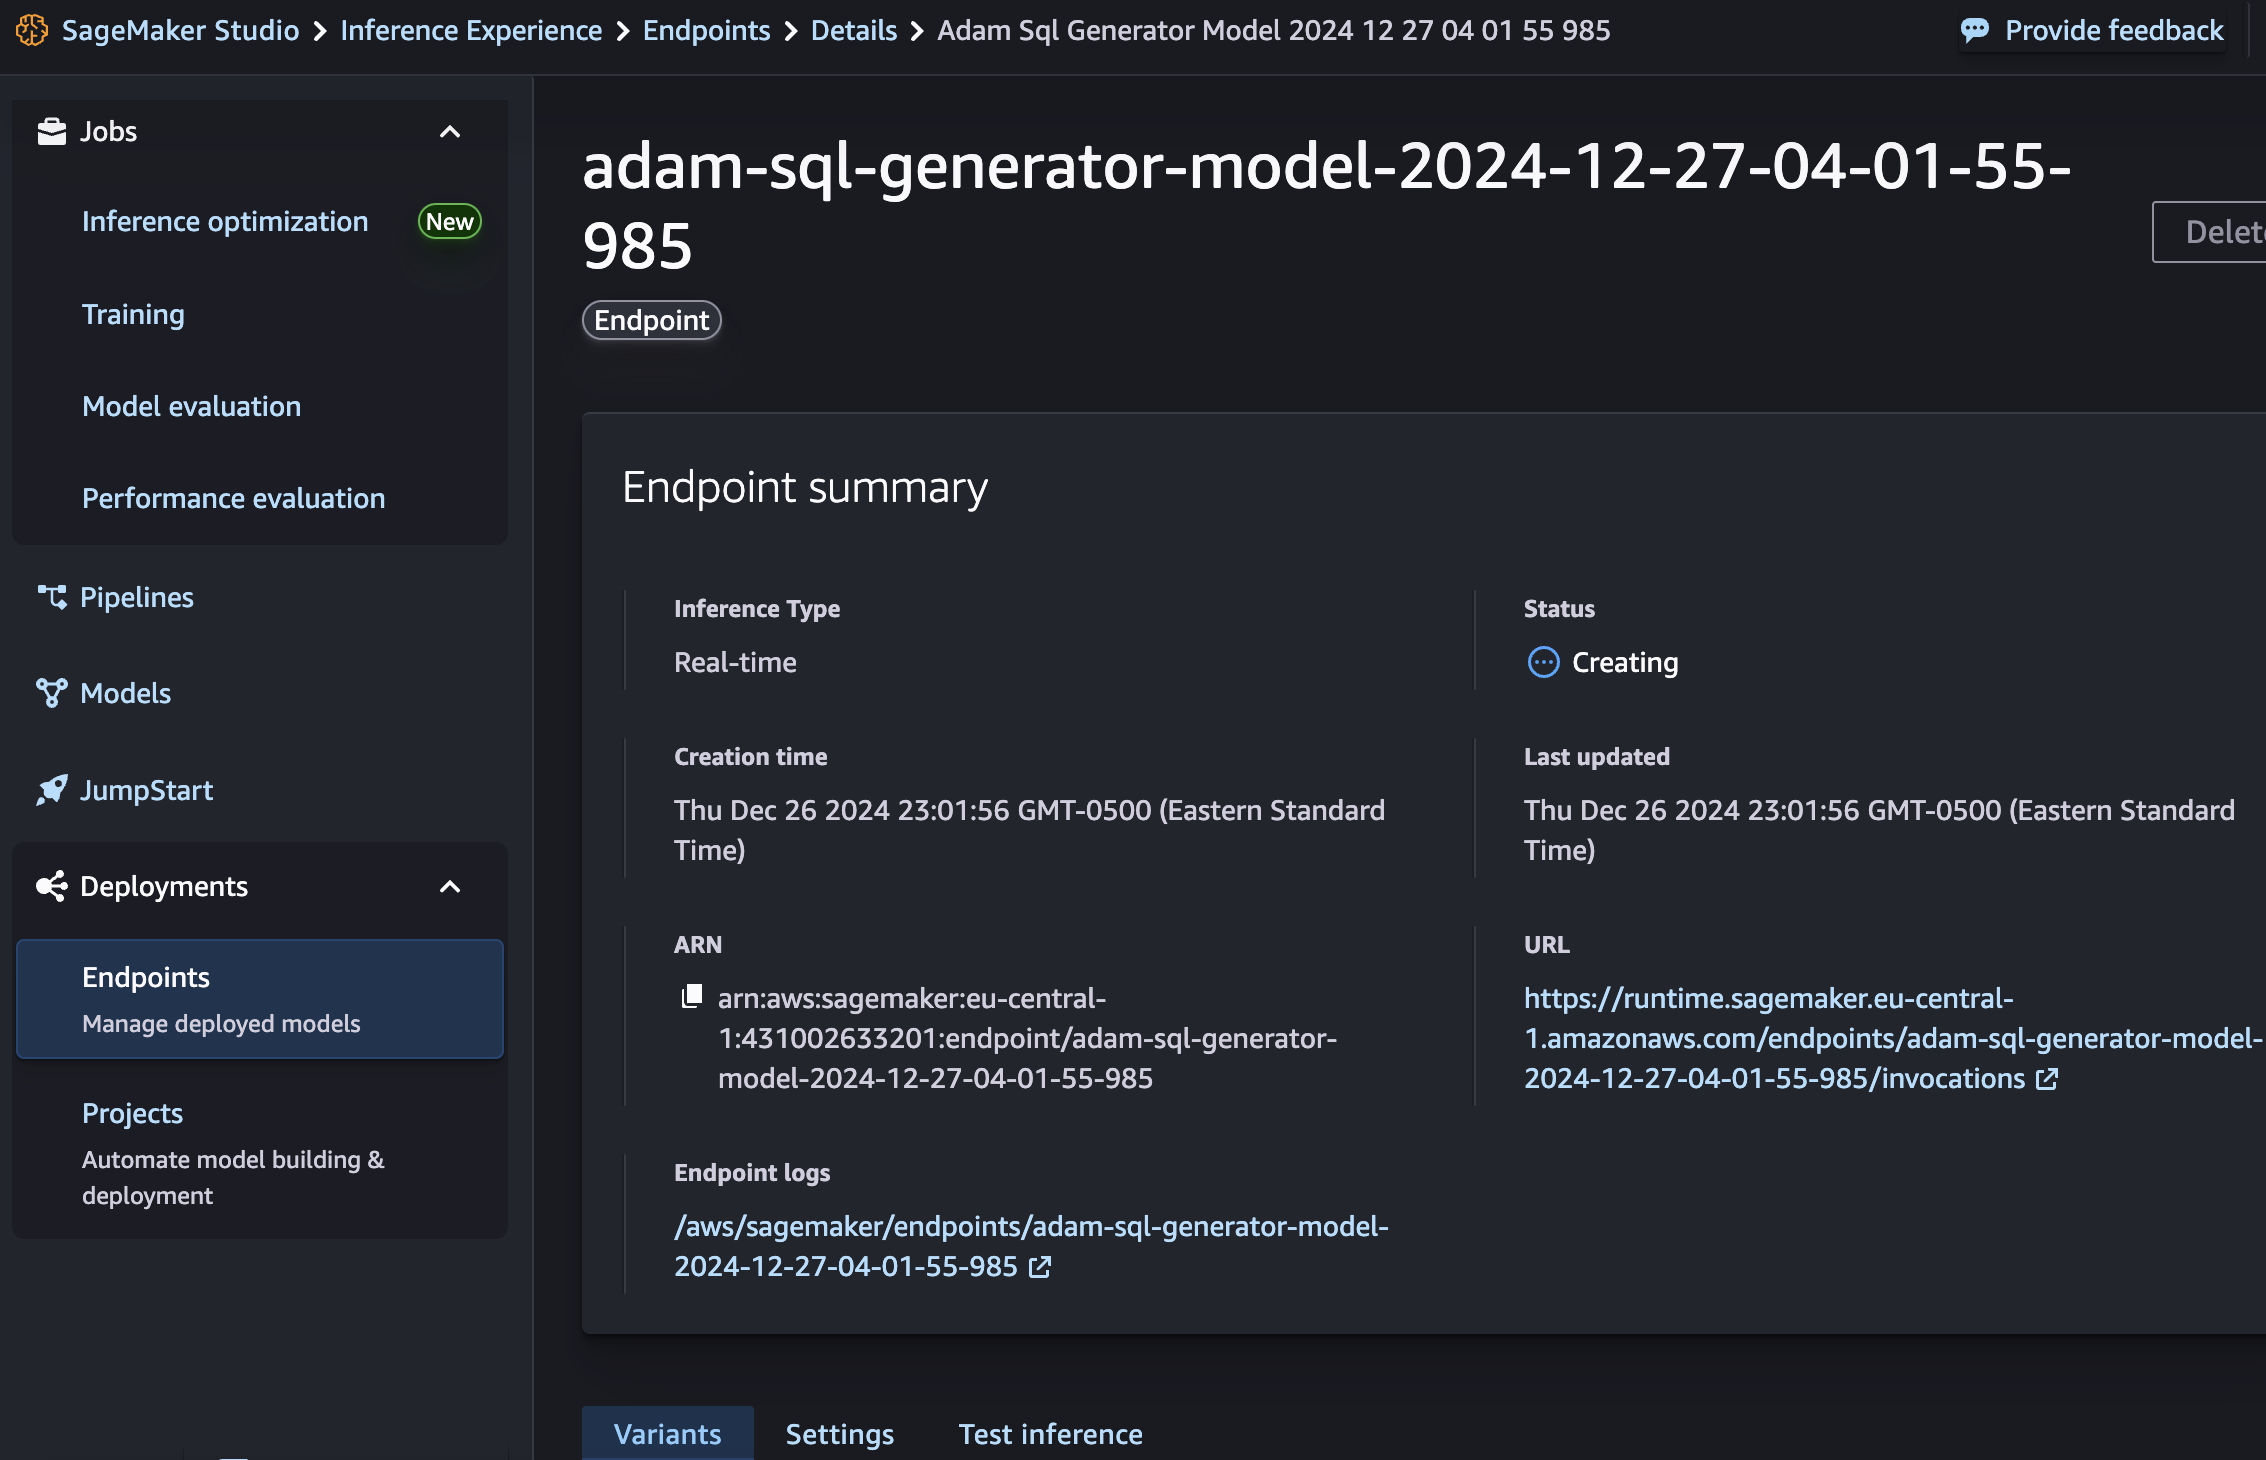

# Evaluation

In [39]:
import os
from transformers import AutoTokenizer
from sagemaker import Predictor
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer
from datasets import load_dataset

os.makedirs('./tmp', exist_ok=True)
tokenizer = AutoTokenizer.from_pretrained(model_id)

## create boto3 client
boto3.client('s3').download_file(s3_bucket, test_path, test_local)
test_dataset = load_dataset("json", data_files=test_local, split="train")

# or put endpoint name from UI
## create instance of predictor
deployed_llm = Predictor(
    endpoint_name=llm.endpoint_name,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
)

## helper function to get predictions and evaluate model
def request(sample):
    prompt = tokenizer.apply_chat_template(sample, tokenize=False, add_generation_prompt=True)
    print(f"prompt:\n {prompt} \n\n")
    outputs = deployed_llm.predict({
      "inputs": prompt,
      "parameters": {
        "max_new_tokens": 512,
        "temperature": 0.01,
        "return_full_text": False,
      }
    })
    return {"role": "assistant", "content": outputs[0]["generated_text"].strip()}

## take a random sample
random_sample = test_dataset[10]
print(f"input message:\n {random_sample['messages'][0]} \n\n")
print(f"expected output:\n {random_sample['messages'][1]} \n\n")
print(f"generated output:\n {request([random_sample['messages'][0]])} \n\n")

Generating train split: 0 examples [00:00, ? examples/s]

input message:
 {'content': ' \nYou are a database management system expert, proficient in Structured Query Language (SQL). \nYour job is to write an SQL query that answers the following question, based on the given database schema and any additional information provided. \nUse SQLite syntax and please output only SQL without any kind of explanations. \n### Schema: CREATE TABLE donations (donation_id INT, donation_date DATE, donation_amount FLOAT); INSERT INTO donations (donation_id, donation_date, donation_amount) VALUES (1, \'2022-01-01\', 25000.00), (2, \'2022-02-01\', 30000.00); \n \n### Knowledge: This "analytics and reporting" type task is commonly used for generating reports, dashboards, and analytical insights in the domain of nonprofit, which involves Nonprofit data on charitable giving trends, social impact assessment, capacity building, and volunteer management.. \n \n### Question: What is the maximum donation amount given in the year 2022? \n', 'role': 'user'} 


expected o

Summary:
* The output was not ideal as we can see but we didnt train it for that long. If we trained it longer and adjusted some hyperparameters we can improve the generated outputs.

# Final Step
* Delete model
* Delete endpoint
* This is a good idea to save money for your AWS account usage. 

In [43]:
deployed_llm.delete_model()
deployed_llm.delete_endpoint()

INFO:sagemaker:Deleting model with name: adam-sql-generator-model
INFO:sagemaker:Deleting endpoint configuration with name: adam-sql-generator-model-2024-12-27-04-01-55-985
INFO:sagemaker:Deleting endpoint with name: adam-sql-generator-model-2024-12-27-04-01-55-985


# Appendix
* Note, in order to perform some of these actions below, you may need to update your IAM roles such as this:
```
{
    "Version": "2012-10-17",
    "Statement": [
{
			"Sid": "AllowS3PutObject",
			"Effect": "Allow",
			"Action": [
				"s3:PutObject",
				"s3:GetObject",
				"s3:ListBucket",
				"sagemaker:DeleteModel",
				"sagemaker:DeleteEndpoint",
                "sagemaker:DeleteEndpointConfig"
			],
			"Resource": [
				"arn:aws:s3:::adam-llmops-sagemaker-test/*",
				"arn:aws:s3:::sagemaker-eu-central-1-431002633201/*",
				"arn:aws:s3:::sagemaker-eu-central-1-431002633201",
				"arn:aws:sagemaker:eu-central-1:431002633201:model/*",
				"arn:aws:sagemaker:eu-central-1:431002633201:endpoint/*",
                "arn:aws:sagemaker:eu-central-1:431002633201:endpoint-config/*"
			]
```